# Soft Actor-Critic

* https://proceedings.mlr.press/v80/haarnoja18b
* https://arxiv.org/abs/1812.05905
* https://spinningup.openai.com/en/latest/algorithms/sac.html

In [1]:
from collections import defaultdict
from copy import deepcopy
from itertools import chain

import gymnasium as gym
import mediapy
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import NormalizeObservation
from livelossplot import PlotLosses
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions import Normal

## Data

In [2]:
class ReplayBuffer:
    def __init__(self, obs_dim, action_dim, capacity):
        self.obs_buf = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.action_buf = np.zeros((capacity, action_dim), dtype=np.float32)
        self.reward_buf = np.zeros((capacity, 1), dtype=np.float32)
        self.next_obs_buf = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.done_buf = np.zeros((capacity, 1), dtype=np.float32)
        self.capacity = capacity
        self.ptr, self.size = 0, 0

    def append(self, obs, action, reward, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.action_buf[self.ptr] = action
        self.reward_buf[self.ptr] = reward
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size, device):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {
            'obs': torch.tensor(self.obs_buf[idxs], device=device),
            'action': torch.tensor(self.action_buf[idxs], device=device),
            'reward': torch.tensor(self.reward_buf[idxs], device=device),
            'next_obs': torch.tensor(self.next_obs_buf[idxs], device=device),
            'done': torch.tensor(self.done_buf[idxs], device=device),
        }

## Model

In [3]:
class DeviceMixin:
    @property
    def device(self):
        return next(self.parameters()).device

In [4]:
class Actor(nn.Module, DeviceMixin):
    def __init__(self, obs_dim, action_dim, hidden_dim, action_limit):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(hidden_dim, action_dim)
        self.log_std_layer = nn.Linear(hidden_dim, action_dim)
        self.action_limit = action_limit

    def forward(self, obs):
        h = self.net(obs)
        mu = self.mu_layer(h)
        log_std = self.log_std_layer(h)
        std = log_std.clamp(min=-20, max=2).exp()
        return Normal(mu, std)

    def log_prob(self, obs):
        dist = self.forward(obs)
        action = dist.rsample()
        # Numerically stable log_prob of tanh-squashed Gaussian
        log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)
        log_prob -= (2*(np.log(2) - action - F.softplus(-2*action))).sum(dim=-1, keepdim=True)
        return self._squash_action(action), log_prob

    def sample_action(self, obs):
        obs = torch.tensor(obs, device=self.device)
        action = self.forward(obs).sample()
        action = self._squash_action(action)
        return action.cpu().numpy()

    def get_action(self, obs):
        obs = torch.tensor(obs, device=self.device)
        action = self.forward(obs).mean
        action = self._squash_action(action)
        return action.cpu().numpy()

    def _squash_action(self, action):
        return torch.tanh(action) * self.action_limit

In [5]:
class Critic(nn.Module, DeviceMixin):
    def __init__(self, obs_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=-1)
        return self.net(x)

    def freeze(self, freeze=True):
        for param in self.parameters():
            param.requires_grad = not freeze

In [6]:
class ActorCritic(nn.Module, DeviceMixin):
    def __init__(self, obs_dim, action_dim, hidden_dim, action_limit, gamma=0.99):
        super().__init__()
        self.pi = Actor(obs_dim, action_dim, hidden_dim, action_limit)
        self.q1 = Critic(obs_dim, action_dim, hidden_dim)
        self.q2 = Critic(obs_dim, action_dim, hidden_dim)
        self.log_alpha = nn.Parameter(torch.tensor(0.0))
        self.target_entropy = -action_dim
        self.gamma = gamma

    def compute_q_loss(self, batch, target):
        b = batch
        q1 = self.q1(b['obs'], b['action'])
        q2 = self.q2(b['obs'], b['action'])

        with torch.no_grad():
            # Use current policy to sample target actions
            next_action, logp = self.pi.log_prob(b['next_obs'])
            # Use target network to compute target Q-value
            next_q = torch.min(
                target.q1(b['next_obs'], next_action),
                target.q2(b['next_obs'], next_action),
            )
            backup = b['reward'] + (1 - b['done']) * self.gamma * (next_q - self.alpha * logp)

        loss = F.mse_loss(q1, backup) + F.mse_loss(q2, backup)
        info = {
            'q1': q1.mean().item(),
            'q2': q2.mean().item(),
        }
        return loss, info

    def compute_pi_loss(self, batch):
        obs = batch['obs']
        action, logp = self.pi.log_prob(obs)
        q = torch.min(self.q1(obs, action), self.q2(obs, action))
        pi_loss = (self.alpha * logp - q).mean()
        aloha_loss = -(self.log_alpha * (logp.detach() + self.target_entropy)).mean()
        info = {
            'pi_q': q.mean().item(),
            'entropy': -logp.mean().item(),
        }
        return pi_loss, aloha_loss, info

    def freeze_q(self, freeze=True):
        self.q1.freeze(freeze)
        self.q2.freeze(freeze)

    @property
    def alpha(self):
        return self.log_alpha.exp()

## Training

In [7]:
@torch.no_grad()
def polyak_average(target_model, model, tau):
    for target_param, param in zip(target_model.parameters(), model.parameters()):
        target_param.data.mul_(1 - tau)
        target_param.data.add_(tau * param.data)
    return target_model

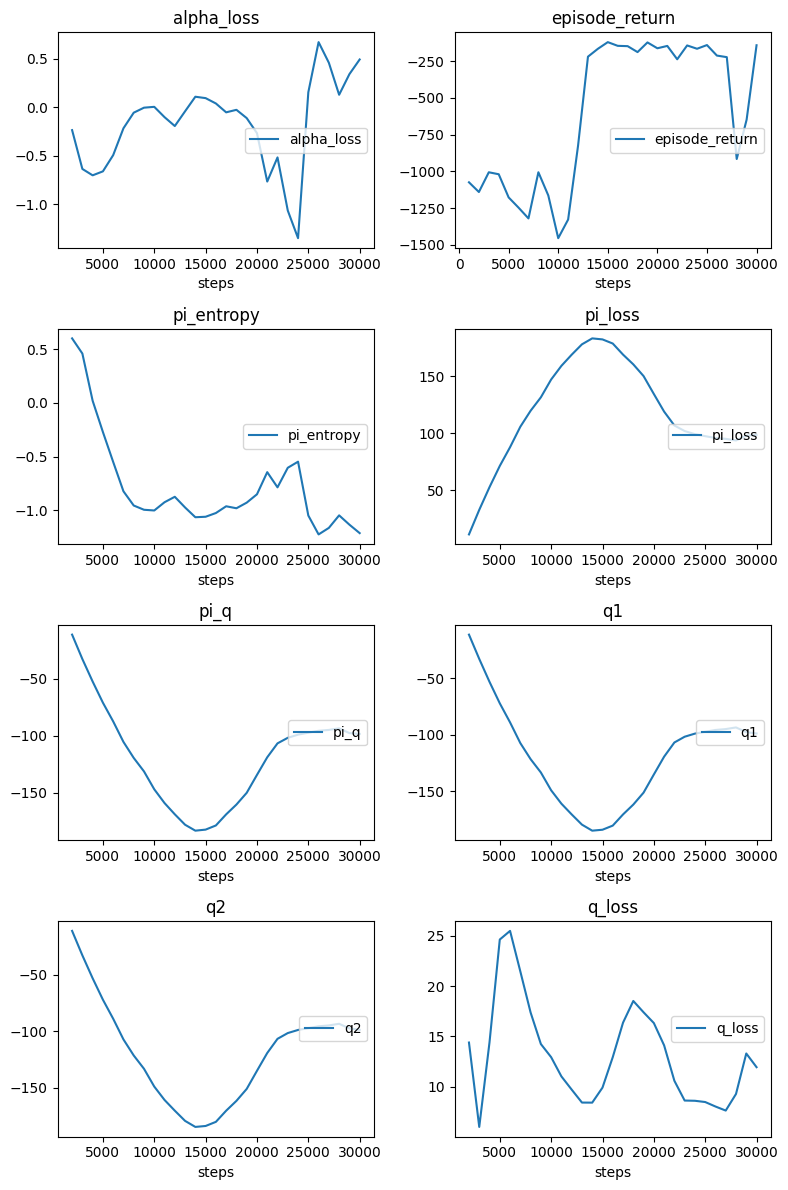

alpha_loss
	alpha_loss       	 (min:      nan, max:      nan, cur:    0.491)
episode_return
	episode_return   	 (min: -1454.019, max: -120.004, cur: -141.213)
pi_entropy
	pi_entropy       	 (min:      nan, max:      nan, cur:   -1.213)
pi_loss
	pi_loss          	 (min:      nan, max:      nan, cur:   98.604)
pi_q
	pi_q             	 (min:      nan, max:      nan, cur:  -98.482)
q1
	q1               	 (min:      nan, max:      nan, cur:  -98.787)
q2
	q2               	 (min:      nan, max:      nan, cur:  -98.790)
q_loss
	q_loss           	 (min:      nan, max:      nan, cur:   11.935)


In [8]:
env_name = "Pendulum-v1"
hidden_dim = 64

learning_rate = 3e-4
gamma = 0.99
tau = 0.005

replay_size = 10000
batch_size = 100

num_steps = 30000
start_steps = 10000
update_after = 1000
update_every = 50
log_interval = 1000

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

env = NormalizeObservation(gym.make(env_name, render_mode="rgb_array"))
test_env = NormalizeObservation(gym.make(env_name, render_mode="rgb_array"))
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_limit = env.action_space.high[0]
target_entropy = -action_dim

ac = ActorCritic(obs_dim, action_dim, hidden_dim, action_limit, gamma).to(device)
ac_target = deepcopy(ac)
pi_optimizer = optim.Adam(ac.pi.parameters(), lr=learning_rate)
q_optimizer = optim.Adam(chain(ac.q1.parameters(), ac.q2.parameters()), lr=learning_rate)
alpha_optimizer = optim.Adam([ac.log_alpha], lr=learning_rate)

buffer = ReplayBuffer(obs_dim, action_dim, replay_size)

logs = PlotLosses(figsize=(8, 12), step_names='steps')
stats = defaultdict(list)
obs, _ = env.reset()
ep_return = 0
for step in range(num_steps):
    # Collecting experience
    if step < start_steps:
        action = env.action_space.sample()
    else:
        with torch.inference_mode():
            action = ac.pi.sample_action(obs)

    next_obs, reward, terminated, truncated, _ = env.step(action)
    buffer.append(obs, action, reward, next_obs, terminated)
    ep_return += reward
    obs = next_obs

    if terminated or truncated:
        obs, _ = env.reset()
        stats['ep_return'].append(ep_return)
        ep_return = 0

    # Updating policy and Q-networks
    if step >= update_after and (step + 1) % update_every == 0:
        for _ in range(update_every):
            batch = buffer.sample(batch_size, device)

            # Update Q-networks
            q_loss, q_info = ac.compute_q_loss(batch, ac_target)
            q_optimizer.zero_grad()
            q_loss.backward()
            q_optimizer.step()

            # Update policy network
            ac.freeze_q()
            pi_loss, alpha_loss, pi_info = ac.compute_pi_loss(batch)

            pi_optimizer.zero_grad()
            pi_loss.backward()
            pi_optimizer.step()

            alpha_optimizer.zero_grad()
            alpha_loss.backward()
            alpha_optimizer.step()
            ac.freeze_q(False)

            ### Update target network
            polyak_average(ac_target, ac, tau)

            stats['q_loss'].append(q_loss.item())
            stats['q1'].append(q_info['q1'])
            stats['q2'].append(q_info['q2'])
            stats['pi_loss'].append(pi_loss.item())
            stats['pi_q'].append(pi_info['pi_q'])
            stats['alpha_loss'].append(alpha_loss.item())
            stats['entropy'].append(pi_info['entropy'])

    if (step + 1) % log_interval == 0:
        logs.update({
            'q_loss': np.mean(stats['q_loss']),
            'q1': np.mean(stats['q1']),
            'q2': np.mean(stats['q2']),
            'pi_loss': np.mean(stats['pi_loss']),
            'pi_q': np.mean(stats['pi_q']),
            'pi_entropy': np.mean(stats['entropy']),
            'alpha_loss': np.mean(stats['alpha_loss']),
            'episode_return': np.mean(stats['ep_return']),
        }, current_step=step)
        logs.send()
        stats = defaultdict(list)

## Evaluation

In [9]:
eval_episodes = 30

returns = []
for _ in range(eval_episodes):
    obs, _ = env.reset()
    done = False
    ep_return = 0
    while not done:
        with torch.inference_mode():
            action = ac.pi.get_action(obs)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ep_return += reward
        obs = next_obs
    returns.append(ep_return)

print(f"Average return: {np.mean(returns):.2f}")


Average return: -141.27


## Sampling

In [10]:
obs, _ = env.reset()
done = False
frames = [env.render()]
rewards = []
while not done:
    with torch.inference_mode():
        action = ac.pi.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    obs = next_obs
    rewards.append(reward)
    frames.append(env.render())

mediapy.show_video(frames, fps=60)